#Importing Data

In [ ]:
import urllib.request
import zipfile

# Correct URL to download the raw zip file from GitHub
zip_url = 'https://github.com/YusufMehmetColak/FFN_CLASSIFICATION/raw/main/input_data.zip'

# Download the zip
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = 'temp'

# Reading the data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

import pickle as pk

# Assuming 'input_data.pkl' is within the extracted 'temp' folder
with open(f'{target_folder}/input_data.pkl', 'rb') as f:
    data = pk.load(f)

X = data['X']  # Accessing 'X' directly from the loaded data dictionary
y = data['y']
print(X.shape)
print(y.shape)

(2700, 132)
(2700,)


**NOTE:** I just wanted to plot a sample for curiosity. It was not written on the paper

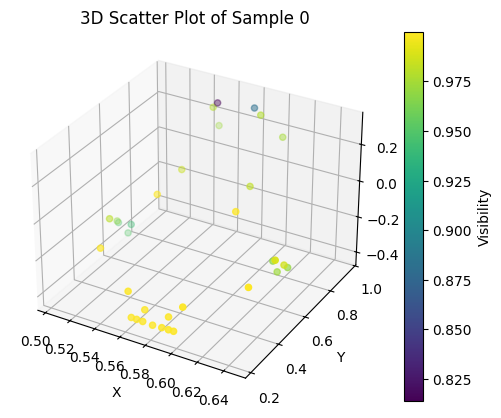

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Select the first sample and reshape it to (33, 4) -> (x, y, z, v)
sample_0 = X[0].reshape(33, 4)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(sample_0[:, 0], sample_0[:, 1], sample_0[:, 2], c=sample_0[:, 3], cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(sc, label="Visibility")
plt.title("3D Scatter Plot of Sample 0")
plt.show()

# Preprocessing (corresponds to 2a.)

Checking if the labels are really strings.

In [ ]:
# Print unique string labels in y
unique_labels = set(y)
unique_labels

{'left_bicep',
 'left_shoulder',
 'left_tricep',
 'rest',
 'right_bicep',
 'right_shoulder',
 'right_tricep'}

Transforming the labels to one hot

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Ensure 'y' is a NumPy array and reshape it to 2D
y = np.array(y).reshape(-1, 1)

# Initialize and apply OneHotEncoder (removed 'sparse=False')
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
y_one_hot = encoder.fit_transform(y)

# Print the shape to verify
print("Shape of one-hot encoded labels:", y_one_hot.shape)

# Example: Check first few transformed labels
print(y_one_hot[:5])

Shape of one-hot encoded labels: (2700, 7)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


Checking missing values

In [ ]:
# Check for missing values in the dataset
missing_values_X = np.isnan(X).sum()
missing_values_y = np.isnan(y).sum() if y.dtype.kind in 'f' else 0  # Check only if y is numeric

# Display the number of missing values
missing_values_X, missing_values_y

(0, 0)

# The input shape of the data (2.b)

In [ ]:
import numpy as np

# Ensure X has the correct shape
X_reshaped = X.reshape(-1, 132)  # Ensures it remains (2700, 132)

# Print the final shape to confirm
print("Final input shape:", X_reshaped.shape)

Final input shape: (2700, 132)


# Data Splitting & Mini-Batch Preparation (5.c)
***NOTE: I am talking about the mini bath approach and uniform distribution of the classes to each batch at 5c section of exam.***

✅ Split Data into Training & Validation Sets -> *NOTE!!*: **I didnt explicitly indicate that I will split data as train, test,and validation but I thought this is obvious since I indicate to use mini-batch approach and ensure that at each batch there is going to be same amount of class distrubition to handle class imbalance. I thought this ensures that there is going to be definetely a training and test set**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Step 0: First, Split Data into Training (80%) and Test (20%) Sets

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_reshaped, y_one_hot, test_size=0.2, stratify=np.argmax(y_one_hot, axis=1), random_state=42
)
# Step 1: Split Data into Training & Validation Sets (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=np.argmax(y_train_full, axis=1), random_state=42 # Changed here to use y_train_full
)

# Step 2: Convert One-Hot Labels to Integer Labels for Stratified Batching
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Step 3: Define Batch Size and Ensure Class Balance
batch_size = 128
num_classes = len(np.unique(y_train_labels))
samples_per_class_per_batch = batch_size // num_classes

# Group Indices by Class
class_indices = {label: np.where(y_train_labels == label)[0] for label in np.unique(y_train_labels)}

# Ensure Each Class Contributes Equally to Each Batch
stratified_batches = []
num_batches = len(X_train) // batch_size

for _ in range(num_batches):
    batch_indices = []
    for label, indices in class_indices.items():
        selected_indices = np.random.choice(indices, samples_per_class_per_batch, replace=False)
        batch_indices.extend(selected_indices)

    stratified_batches.append((X_train[batch_indices], y_train[batch_indices]))

# Step 4: Check Class Distribution in the First Batch
first_batch_X, first_batch_y = stratified_batches[0]
unique_classes, counts = np.unique(np.argmax(first_batch_y, axis=1), return_counts=True)

# Print Class Distribution in First Batch
print("Class distribution in first batch:", dict(zip(unique_classes, counts)))

Class distribution in first batch: {0: 18, 1: 18, 2: 18, 3: 18, 4: 18, 5: 18, 6: 18}


# **Define & Compile the Model - Set Model Evaluation Technique (5.a, 5.b, and 6)**
Feedforward Neural Network (FNN) using TensorFlow:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1


# Define L1 regularization strength (λ)
l1_lambda = 0.001

# Step 1: Define the Model Architecture
model = Sequential([
    Dense(512, input_shape=(132,), kernel_regularizer=l1(l1_lambda)),     # Input layer with 132 features
    LeakyReLU(alpha=0.01),           # First hidden layer with LeakyReLU (question on 4 on exam)
    Dropout(0.3),                    # Dropout for regularization

    Dense(256, kernel_regularizer=l1(l1_lambda)),
    LeakyReLU(alpha=0.01),           # Second hidden layer with LeakyReLU(question on 4 on exam)
    Dropout(0.3),

    Dense(128, kernel_regularizer=l1(l1_lambda)),
    LeakyReLU(alpha=0.01),           # Third hidden layer with LeakyReLU(question on 4 on exam)
    Dropout(0.2),

    Dense(64, kernel_regularizer=l1(l1_lambda)),
    LeakyReLU(alpha=0.01),           # fourth hidden layer with LeakyReLU(question on 4 on exam)
    Dropout(0.2),

    Dense(7, activation='softmax')   # Output layer with 7 neurons (for 7 classes) (question 3 on exam)
])
# Step 1: Define a Custom F1-Score Metric
def f1_score(y_true, y_pred):
    y_pred_classes = K.argmax(y_pred, axis=1)  # Get predicted class indices
    y_true_classes = K.argmax(y_true, axis=1)  # Get true class indices

    # Convert to one-hot encoding
    y_pred_one_hot = K.one_hot(y_pred_classes, num_classes=7)
    y_true_one_hot = K.one_hot(y_true_classes, num_classes=7)

    tp = K.sum(y_true_one_hot * y_pred_one_hot, axis=0)
    fp = K.sum(y_pred_one_hot, axis=0) - tp
    fn = K.sum(y_true_one_hot, axis=0) - tp

    precision = tp / (tp + fp + K.epsilon())  # Avoid division by zero
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)  # Return macro F1-score (average over all classes)

# Step 2: Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer
    loss=CategoricalCrossentropy(),      # Categorical Cross-Entropy loss
    metrics=[f1_score]                  # Use f1_score as an evaluation metric
)

# Print Model Summary
model.summary()

# Step 3: Define Early Stopping Callback (to prevent overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("✅ Model successfully defined and compiled! Ready for training.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 512)                 │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,031 (941.53 KB)

 Trainable params: 241,031 (941.53 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model successfully defined and compiled! Ready for training.


# Training the Model with Balanced Mini-Batches (5.c)

✅ Train the Model Using Mini-Batches


  •	Use validation_split=0.2 to track overfitting.

  •	Train for 50+ epochs and observe performance.

✅ Monitor Training Progress (6)
  
	•	Check training vs. validation accuracy to detect overfitting.
    •	Plot loss & accuracy curves over epochs.


In [ ]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


# Hyperparameters
epochs = 50
patience = 5  # Early stopping patience (stop if no improvement for 5 epochs)
best_val_loss = np.inf  # Initialize best validation loss
patience_counter = 0

# Lists to store loss & F1-score for plotting
train_losses = []
val_losses = []
val_f1_scores = []


# Step 3: Manual Training Loop with Balanced Mini-Batches & Early Stopping
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    epoch_loss = []

    # Train model using balanced mini-batches
    for batch_X, batch_y in stratified_batches:
        history= model.fit(batch_X, batch_y, verbose=0, epochs=1)  # Fit batch by batch
        epoch_loss.append(history.history['loss'][0])  # Store batch loss

   # Compute average loss for the epoch
    avg_train_loss = np.mean(epoch_loss)
    train_losses.append(avg_train_loss)
    # Evaluate model on validation data
    val_loss, val_f1 = model.evaluate(X_val, y_val, verbose=0)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    print(f"Validation Loss: {val_loss:.4f}, Validation F1-Score: {val_f1:.4f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter
        model.save_weights("best_model_weights.weights.h5")
    else:
        patience_counter += 1  # Increment patience counter

    # Stop training if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print("⏹ Early Stopping Triggered! Restoring Best Model...")
        model.load_weights("best_model_weights.weights.h5")  # Restore best model weights
        break  # Stop training

print("✅ Model Training Completed!")



Epoch 1/50
Validation Loss: 7.1451, Validation F1-Score: 0.1675
Epoch 2/50
Validation Loss: 3.7179, Validation F1-Score: 0.8645
Epoch 3/50
Validation Loss: 2.6207, Validation F1-Score: 0.8144
Epoch 4/50
Validation Loss: 2.0747, Validation F1-Score: 0.9857
Epoch 5/50
Validation Loss: 1.7310, Validation F1-Score: 0.9812
Epoch 6/50
Validation Loss: 1.5336, Validation F1-Score: 0.9959
Epoch 7/50
Validation Loss: 1.3712, Validation F1-Score: 0.9812
Epoch 8/50
Validation Loss: 1.2805, Validation F1-Score: 0.9920
Epoch 9/50
Validation Loss: 1.1897, Validation F1-Score: 0.9812
Epoch 10/50
Validation Loss: 1.1374, Validation F1-Score: 0.9830
Epoch 11/50
Validation Loss: 1.0444, Validation F1-Score: 0.9935
Epoch 12/50
Validation Loss: 1.0022, Validation F1-Score: 0.9830
Epoch 13/50
Validation Loss: 0.9569, Validation F1-Score: 0.9812
Epoch 14/50
Validation Loss: 0.9051, Validation F1-Score: 0.9812
Epoch 15/50
Validation Loss: 0.8655, Validation F1-Score: 0.9812
Epoch 16/50
Validation Loss: 0.826

# Plotting the values for better interpretibality (7)

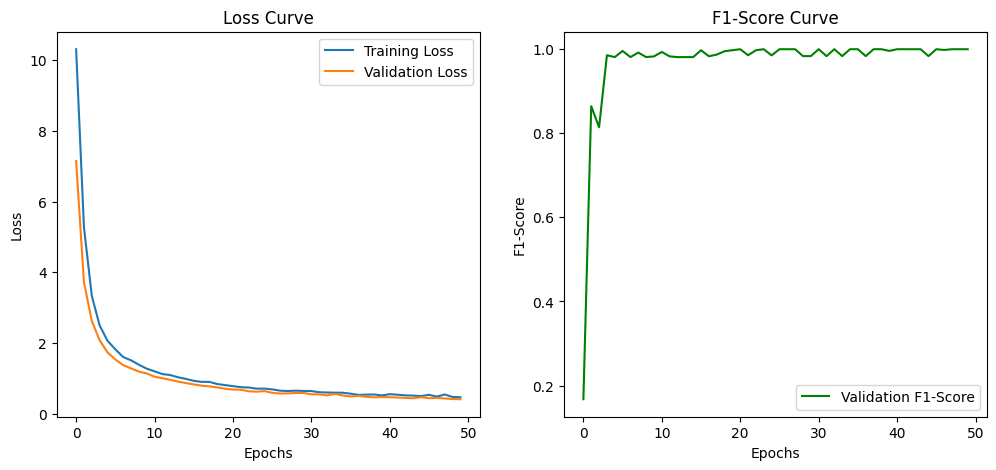

In [ ]:
# Step 4: Plot Loss & F1-Score Curves
plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot F1-Score Curve
plt.subplot(1, 2, 2)
plt.plot(range(len(val_f1_scores)), val_f1_scores, label='Validation F1-Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.legend()

plt.show()

✔ Training loss & validation loss decrease together

✔ Validation loss does not start increasing

✔ Validation F1-score is stable & high

# Model Evaluation (6)

✅ Evaluate on Test Data
	•	Compute accuracy, precision, recall, and F1-score on unseen test data.

✅ Check for Overfitting
	•	If training accuracy >> validation accuracy, apply dropout/l1-l2 regularization.

✅ Confusion Matrix Analysis
	•	Identify which classes are misclassified the most.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Evaluate the Model on Test Data
test_loss, test_f1 = model.evaluate(X_test, y_test, verbose=0)

# Convert predictions to class labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert true labels from one-hot

# Step 2: Compute Accuracy, Precision, Recall, and F1-Score
report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("📌 Classification Report:\n", report)



17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
📌 Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        87
           1     1.0000    1.0000    1.0000        75
           2     1.0000    1.0000    1.0000        63
           3     1.0000    1.0000    1.0000        81
           4     1.0000    1.0000    1.0000        74
           5     1.0000    1.0000    1.0000        80
           6     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       540
   macro avg     1.0000    1.0000    1.0000       540
weighted avg     1.0000    1.0000    1.0000       540



#Checking If there is overfitting

*Ensuring that the training and test samples are not the same*

In [ ]:
print("First Training Sample:", X_train[0])
print("First Test Sample:", X_test[0])

First Training Sample: [ 0.6336633   0.24100241 -0.21640432  0.99998564  0.64125091  0.22889151
 -0.20406358  0.9999671   0.64570326  0.22947283 -0.20413518  0.99997526
  0.65010709  0.23028506 -0.20416617  0.99997592  0.62897718  0.22840527
 -0.18943249  0.99992067  0.62608612  0.22861055 -0.18942106  0.99991369
  0.62375844  0.22901763 -0.18937568  0.99989599  0.65826583  0.23995781
 -0.10726289  0.99998695  0.62163728  0.23915029 -0.04699402  0.99983913
  0.64263886  0.26028135 -0.18121701  0.99999094  0.62729049  0.25864309
 -0.16325618  0.99996173  0.69476759  0.34363997 -0.10524571  0.99999434
  0.58800352  0.32300919  0.08183564  0.99973524  0.6977185   0.46391612
 -0.1283385   0.99826658  0.53053266  0.33075306  0.13320947  0.95222318
  0.69261551  0.58330214 -0.22253945  0.9972471   0.46716699  0.31374535
  0.03009341  0.98412466  0.69368112  0.61888528 -0.24960737  0.99067187
  0.44617087  0.31578293  0.0128038   0.96872139  0.68363041  0.61688179
 -0.28357616  0.99118537  0.

In [ ]:
import numpy as np

# Check if any test sample exists in the training set
for i, test_sample in enumerate(X_test):
    if any(np.all(test_sample == train_sample) for train_sample in X_train):
        print(f"⚠ Data Leakage Found! Test Sample {i} is in Training Data.")

I try to understand why i get soo high F1_scores.I thougth maybe there was a data leakage or maybe accidently I used same datasets for test and train. But the problem was not this. I think there is no problem. *When I print the test and train values I saw that they are very close to each other. So the case is actually about the data itself not about my application.*


#  Model Interpretation & Explainability (7)

✅ Use Feature Importance Analysis (LIME)
	•	Explain which features influence predictions the most.

✅ Visualize Predictions
	•	Plot test samples with their predicted vs. actual labels.

In [ ]:
!pip install lime  # Install the lime package


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c1b1b514b9e3215d294f4923f252f45b32df8bbefe8c8de050a6fa3266d77455
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
🔍 Explanation for Test Sample 147 (True Class: 0):


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


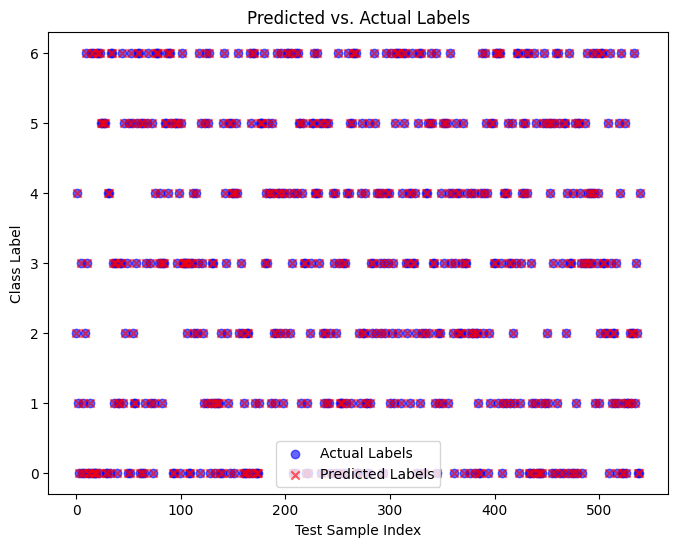

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,  # Use training data as reference
    feature_names=[f"Feature {i}" for i in range(X_train.shape[1])],  # Assign feature names
    class_names=[str(i) for i in range(y_train.shape[1])],  # Assign class labels
    mode="classification"
)

# Step 2: Select a Test Sample for Explanation
sample_idx = np.random.randint(0, len(X_test))  # Pick a random test sample
sample_input = X_test[sample_idx].reshape(1, -1)
sample_label = np.argmax(y_test[sample_idx])  # Get true class label

# Step 3: Generate Explanation
# Use model.predict directly and get probabilities using softmax
def predict_proba(X):
    return tf.nn.softmax(model.predict(X)).numpy()

exp = explainer.explain_instance(sample_input.flatten(), predict_proba, num_features=10)

# Step 4: Display LIME Explanation
print(f"🔍 Explanation for Test Sample {sample_idx} (True Class: {sample_label}):")
exp.show_in_notebook()  # Shows LIME output inside Jupyter Notebook

# Step 5: Visualize Predictions (Predicted vs. Actual Labels)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_true_classes, color="blue", label="Actual Labels", alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_classes, color="red", marker="x", label="Predicted Labels", alpha=0.6)
plt.xlabel("Test Sample Index")
plt.ylabel("Class Label")
plt.title("Predicted vs. Actual Labels")
plt.legend()
plt.show()

# Interpretations

I have tried with different samples even though the model is not highly certain about its desicion in general (the probablities given classes are low and generally distributed along the classes) model is highly capabale of predicting the right class. Also when we look to the Predicted vs. Actual labels table we see a similar pattern that every sample is predicted to the right class.